#  Data Handling for Time Dependent Parameters
* recieve data on external parameters and consumption profiles
* index them with the datetime format
* plot the given data for validation

Author: nils ter-borch \
Context: EPFL master project on Farm energy systems - spring 2020

In [1]:
# Modules for Data Reception
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# displax options for pandas
pd.set_option("display.precision", 3)

# uncomment to choose a signle day for simplification
# day = '2020-01-01'
day = '2019-07-05'

## External temporal parameters
* Irradiance in $W/m^2$
* Temperature in $C^\circ$
* Sample frequency 10min
* Sample period first jan 2019 to first an 2020
* Sample location Liebensberg Switzerland
* Source http://www.agrometeo.ch/fr/meteorology/datas

In [2]:
# open a file in the data folder
def Open_data_csv(file,separator):
     return pd.read_csv(r'C:\Users\poopy\Desktop\PdM\GurobiPy\data\{}'.format(file) , sep = separator, engine='python')

# convert a dataframe column to datetime and reset its index to the date
def To_DateTime(df, column):
    # check if the conversion was already made
    if type(df.index) is not pd.core.indexes.datetimes.DatetimeIndex:
    
        df[[column]] = pd.DataFrame(pd.to_datetime(df[column], format='%d.%m.%Y %H:%M'))
        df.set_index(column, inplace = True)

# Get a timedelta object from a given string
# fromat hrs_min_sec as "00:00:00" hours minutes seconds
def timeD(delta):
    t = datetime.strptime(delta,"%H:%M:%S")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

In [3]:
# cretae a dataframe from a csv file
file = 'meteo_Liebensberg_10min.csv'
df_meteo = Open_data_csv(file,';')

# set the index to a datetime value
To_DateTime(df_meteo, 'Date')

# select a signle day and display it
df_day = df_meteo.truncate(before = day, after = day + ' 23:50:00')

# Display the dataframe
df_day[day + ' 14:00:00': day + ' 15:00:00']

,Irradiance,Temperature
Date,,
2019-07-05 14:00:00,113,28.5
2019-07-05 14:10:00,110,28.6
2019-07-05 14:20:00,108,28.7
2019-07-05 14:30:00,105,28.5
2019-07-05 14:40:00,102,28.7
2019-07-05 14:50:00,99,28.7
2019-07-05 15:00:00,95,28.6


In [4]:
# Downsampling, taking the average Temperature and the sum of Irradiance 
# !!! The units of Irradiance are now Wh/m^2/h = W/m^2
df_day = df_day.resample(timeD("01:00:00")).agg({'Irradiance': np.sum, 'Temperature': np.mean})

# Display the dataframe
df_day[day + ' 10:00:00': day + ' 15:00:00']

,Irradiance,Temperature
Date,,
2019-07-05 10:00:00,742,25.750
2019-07-05 11:00:00,767,26.550
2019-07-05 12:00:00,764,27.300
2019-07-05 13:00:00,719,28.150
2019-07-05 14:00:00,637,28.617
2019-07-05 15:00:00,509,28.550


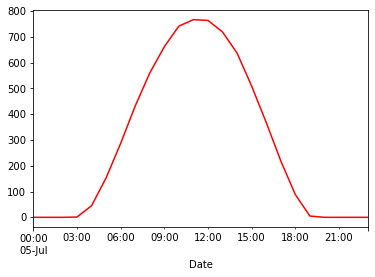

In [5]:
# Plot Irradiance as a function of time
df_day['Irradiance'].plot(color = 'r')
plt.show()

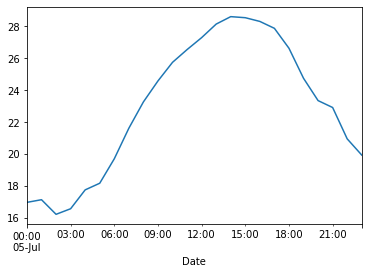

In [6]:
# Plot Temperature as a function of time
df_day['Temperature'].plot()
plt.show()

## Internal temporal parameters
* Electricity consumption profile
* Hot Water consumption profile
* Heating gains profile
* Hourly basis, dummy values based off commerial buildings (ref. Paul Stadler EPFL Thesis 2018)
* Profiles are relative to the peak load (no units)

In [7]:
# handling of a csv file created by user
def handle_csv(file, first_column_index):
    # open the 'unit_costs.csv' file in the data folder
    df = Open_data_csv(file,',')

    # remove the wonky characters from the first column's name
    name = df.columns[0].split('¿')[1]
    df.rename(columns={df.columns[0] : name}, inplace = True)
    
    if first_column_index:
        # set the first column as the dataframe index
        df.set_index(df.columns[0], inplace = True)
    
    return df

In [8]:
# get a user made csv file into a dataframe
file = 'Consumption_profile_dummy.csv'
df_cons = handle_csv(file, False)

# Set the index to match df_day
df_cons.set_index(df_day.index, inplace = True)

# Display the dataframe
df_cons[day + ' 10:00:00': day + ' 15:00:00']

,Electricity,Hot_Water,Gains
Date,,,
2019-07-05 10:00:00,0.20,0.0,0.7
2019-07-05 11:00:00,0.05,0.0,0.5
2019-07-05 12:00:00,0.50,0.0,0.5
2019-07-05 13:00:00,0.70,0.0,0.7
2019-07-05 14:00:00,0.90,0.8,0.9
2019-07-05 15:00:00,1.00,1.0,1.0


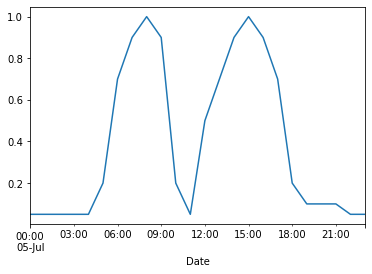

In [9]:
# Plot Temperature as a function of time
df_cons['Electricity'].plot()
plt.show()

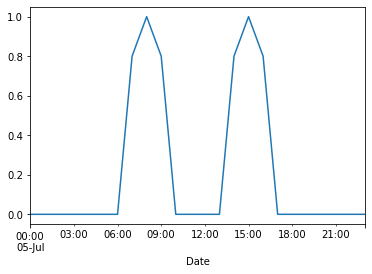

In [10]:
# Plot Temperature as a function of time
df_cons['Hot_Water'].plot()
plt.show()

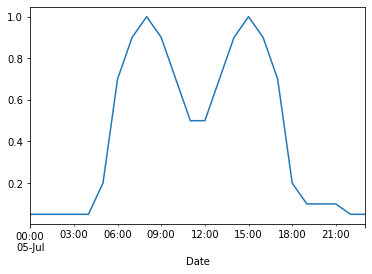

In [11]:
# Plot Temperature as a function of time
df_cons['Gains'].plot()
plt.show()

## Values given by SFF
* electric consumption

In [12]:
# annual electric consumption for the entire site
Annual_Elec_cons = 787000 # kWh

#  Mixed Integer Linnear Model
* Setup the model, select scenario
* Declare sets of units and resources
* Declare model parameters
* Declare model variables
* Model each units
* Connect units and resource with mass and energy balance equations
* Declare model Objective function

## Variables and Parameter Metdada
* Variables metada consist of units and is stored in a dictionnary
* Standalone parameters are created and called using function P()
* Standalone parameter metadata consists of 'Units', 'Description', 'Source', 'Category'
* To easily detect non linearities in constraint equations variables start with minuscule letters and parameters with capital letters

In [13]:
# dictionnary of variable units, to be filled as they are declared
# example: dic_vars_unit['grid_elec_import'] = 'kWh'
dic_vars_unit = {}

# Dictionnary of all standalone model input parameters that are declared individually
# following this format 'Name': ['Value', 'Units', 'Description', 'Source', 'Category']
Param_dict = {}

# Function to get parameter values (if only Name is passed) or declare parameter
# Either no args* or all parmater *args have to be given in order. Only 'Category' can be omitted, and if so will be 'General'.
# Read:  P('Param_name')
# Write: P('Param_name', value', 'Units', 'Description', 'Source', 'Category')
def P(Name, *args):
    # if no args where passed (l is empty) return the value for the querried parameter Name
    if not args:
        return Param_dict[Name][0]
    
    # if args where given, get the value and metadata
    else:
        value = args[0]
        metadata = []
        if type(args[1]) is list:
            for a in args[1]:
                metadata.append(a)
        else:
            for a in args[1:]:
                metadata.append(a)
        
    
        # store the value and metadata in the standalone Parameter dictionary
        if isinstance(value, numbers.Number):
            if len(metadata) == 3:
                Param_dict[Name] = [value] + metadata + ['General']
            elif len(metadata) == 4:
                Param_dict[Name] = [value] + metadata

        # Case of error
        else:
            print('Wrong number of arguments given and or value if not a number')

## Model Settings
* Set the default bound for all variables
* Set solver time limit
* Set specific upper and lower bound for each unit

In [14]:
# Modules for Model description
import gurobipy as gp
from gurobipy import GRB
import numbers

# Create a new model
m = gp.Model("MIP_SFF_v1.6")

# Remove previous model parameters and data
m.resetParams()
m.reset()

# Set solver time limit
m.setParam("TimeLimit", 100.0)

# Default bound for most (all) variables
P('Bound', 10**4, '-', 'Default Variable Upper Bound', 'Gurobi doc')

# Exceptionnaly this parameter is assigned to the python variable Bound
Bound = P('Bound')

# Unit minimum and maximum size
Unit_size_limit = {
    'Unit': ['Lower Bound', 'Upper Bound'],
    'PV':   [0, 100],
    'BAT':  [0, 100],
    'AD':   [0, 100],
    'SOFC': [0, 100],
}

Using license file c:\gurobi901\gurobi.lic
Academic license - for non-commercial use only
Reset all parameters
Discarded solution information
Changed value of parameter TimeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


## Sets of units and resources

In [15]:
# Units and resources
Units_full_name = ['Photovoltaic Panels', 'Battery', 'Solid Oxide Fuel cell', 'Anaerobic Digester']
Units = ['PV', 'BAT', 'SOFC', 'AD']
Resources = ['Elec', 'Biogas', 'Biomass']

# the resources each unit produce
Units_prod = {
    'PV':   ['Elec'],
    'BAT':  ['Elec'], 
    'SOFC': ['Elec'], 
    'AD':   ['Biogas']}

# the resources each unit consumes
Units_cons = {
    'BAT':  ['Elec'], 
    'SOFC': ['Biogas'], 
    'AD':   ['Biomass', 'Elec']}

# the units producing and consuming a given resource
Units_resource = {
    'prod_Elec':['PV', 'BAT', 'SOFC'],
    'cons_Elec':['BAT', 'AD']}

## Parameter declaration
* external and internal temporal parameters
* cost of units
* cost of resources

### Time periods

In [16]:
# index h
Hours = range(0,24)

# index p
Periods = list(Hours)

# hours in a year
Hours_per_year = 365*24

### External Parameters

In [17]:
# Irradiance
Irradiance = list(df_day['Irradiance']) # in [W/m^2]

# Unit change
Irradiance = [Irradiance[p] / 1000 for p in Periods] # in [kW/m^2]

### Farm consumptions

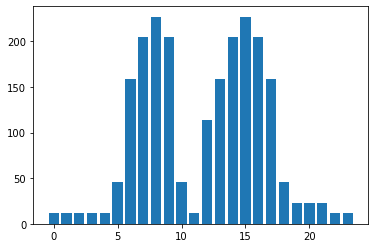

Peak electric consumption: 227 [kW]
Average electric load: 90 [kW]


In [18]:
# Average electric load in kW 
Avrg_cons = Annual_Elec_cons/Hours_per_year

# Average load of the consumption profile in -
Avrg_profile = np.mean(df_cons['Electricity'].values)

# Peak load for to fit the annual electric consumption
Peak_load = Avrg_cons/Avrg_profile

# Load profile in kWh/h
Farm_cons_t = list(df_cons['Electricity'].values*Peak_load) # in [kWh/h]
plt.bar(Periods, Farm_cons_t)
plt.show()
print('Peak electric consumption: {:.0f} [kW]'.format(Peak_load))
print('Average electric load: {:.0f} [kW]'.format(Avrg_cons))

### Farm production

In [19]:
# From SFF - number of animals
category = 'Biomass'
metadata = ['-', 'Number of Pigs', 'swissfuturefarm.ch', category]
P('Pigs', 55, metadata)
P('Cows', 65, metadata)
metadata = ['-', 'LSU per Pigs', 'ec.europa.eu', category]
P('LSU_pigs', 0.5, metadata) # source : https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Livestock_unit_(LSU)

# Live Stock Units
metadata = ['LSU', 'Number of LSU', 'calc', category]
P('LSU', P('Pigs')*P('LSU_pigs') + P('Cows'), metadata)

# From the litterature
# source: C. Font-Palma, “Methods for the Treatment of Cattle Manure—A Review,” C, vol. 5, no. 2, p. 27, May 2019, doi: 10.3390/c5020027.
P('Manure_per_cattle', 7.3, 'kg-dry/day/LSU', 'Cattle manure production', 'doi: 10.3390/c5020027', category)
P('Manure_HHV_dry', 15/3.6, 'kWh/kg-dry', 'Manure energy content', 'doi: 10.3390/c5020027', category)

metadata = ['kWh/h', 'Biomass Production', 'calc', category]
P('Biomass_prod', P('LSU')*P('Manure_per_cattle')*P('Manure_HHV_dry')/24, metadata)
Biomass_prod = [P('Biomass_prod') for p in Periods]
print('Production of biomass, HHV, constant rate: {:.0f} [kW] \nFor {} Live Stock Units'.format(P('Biomass_prod'),P('LSU')))

Production of biomass, HHV, constant rate: 117 [kW] 
For 92.5 Live Stock Units


### Unit Costs

In [20]:
Unit_c = handle_csv('unit_costs.csv', True)

# convert strings of valuesto numpy.int64
pd.to_numeric(Unit_c['Cost_per_size'])
pd.to_numeric(Unit_c['Cost_per_unit'])
pd.to_numeric(Unit_c['Cost_multiplier'])
pd.to_numeric(Unit_c['Life'])

# unit conversion from CHF to kCHF
Unit_c['Cost_per_size'] /= 1000
Unit_c['Cost_per_unit'] /= 1000
# display dataframe
Unit_c

# Life is in years and costs in kCHF

,Cost_per_size,Cost_per_unit,Cost_multiplier,Life,Size_units,Full_name,Source
Technology,,,,,,,
BAT,0.970,0.620,1.33,10,kWh,Battery,Paul regression
BOI,0.105,3.800,1.80,20,kW,Nat Gas boiler,Paul
AHP,1.240,5.680,1.80,20,kW,Air HP,Paul
SOFC,2.100,15.542,1.80,10,kW,SOFC,Paul regression
PV,2.656,2.495,1.33,20,kW,PV,Paul regression
AD,1.500,5.000,1.80,20,kW,Digester,semester project
GC,2.800,3.000,1.80,20,kW,Gas Cleaning,W2W work group 2


In [21]:
# Example accessing a cost parameter
Unit_c['Cost_per_size']['PV']

2.656

### Resource Costs

In [22]:
Resource_c = handle_csv('resource_costs.csv', True)

# convert strings of valuesto numpy.int64
pd.to_numeric(Resource_c['Import_cost'])
pd.to_numeric(Resource_c['Export_cost'])

# unit conversion from CHF to kCHF
Resource_c['Import_cost'] /= 1000
Resource_c['Export_cost'] /= 1000
Resource_c['Units'] = 'kCHF/kWh'

# display dataframe
Resource_c

,Import_cost,Export_cost,Units,Full_name,Source
Flow,,,,,
Elec,2.400e-04,8.000e-05,kCHF/kWh,Electricity,Paul average


## Variable declaration
* variables start with a lower case letter
* set of variables have a dedicated index (signle letter)

In [23]:

# each set of variables are stored in dictionnaries, the keys are the Units
unit_prod_t, unit_cons_t = {}, {}

# size of the installed unit
unit_size = m.addVars(Units, lb = 0, ub = Bound, name="size")

# whether or not the unit is installed
unit_install = m.addVars(Units, lb = 0, ub = Bound, vtype=GRB.BINARY, name="install")

# amount of resource, for each resource a unit produce and consumes during one period, for each period
# Variable format : unit_prod_t['PV'][('Elec',0)]
# Result format : PV_prod_t[Elec,0]
# Result format details: <unit>_<pord or cons>_t[<resource>,<period>]
for u in Units:
    if u in Units_prod:
        unit_prod_t[u] = m.addVars(Units_prod[u], Periods, lb = 0, ub = Bound, name= u + "_prod_t")
    if u in Units_cons:
        unit_cons_t[u] = m.addVars(Units_cons[u], Periods, lb = 0, ub = Bound, name= u + "_cons_t")

# CAPEX of the installed unit
unit_CAPEX = m.addVars(Units, lb = 0, ub = Bound, name="CAPEX")

In [24]:
# Example accessing a variable
unit_prod_t['PV'][('Elec',0)]

<gurobi.Var *Awaiting Model Update*>

## Unit Models

In [25]:

# Size restrictions for each units
o = 'PV_max_size'
m.addConstrs((unit_size[u] <= Unit_size_limit[u][1] for u in Units), o);

o = 'PV_min_size'
m.addConstrs((unit_size[u] >= Unit_size_limit[u][0] for u in Units), o);


### PhotoVoltaïc Panel (PV)

In [26]:
# Parameters
P('PV_eff', 0.14, '-', 'PV efficiency', 'Paul', 'PV')

# Constraints
o = 'PV_production'
m.addConstrs((unit_prod_t['PV'][('Elec',p)] == Irradiance[p] * P('PV_eff') * unit_size['PV'] for p in Periods), o);

### Battery (BAT)

In [27]:
# Variables
bat_SOC_t = m.addVars(Periods + [24], lb = 0, ub = Bound, name = 'bat_SOC_t')

# Parameters
P('BAT_eff', 1, '-', 'BAT roundtrip efficiency', 'guess', 'BAT')

# Constraints
o = 'BAT_SOC'
m.addConstrs((bat_SOC_t[p + 1] - bat_SOC_t[p] == 
              P('BAT_eff') * (unit_cons_t['BAT'][('Elec',p)] - unit_prod_t['BAT'][('Elec',p)]) for p in Periods), o);

o = 'BAT_daily_cycle'
m.addConstr((bat_SOC_t[0] == bat_SOC_t[24]), o);
o = 'BAT_daily_initial'
m.addConstr((bat_SOC_t[0] == 0), o);

o = 'BAT_size_SOC'
m.addConstrs((bat_SOC_t[p] <= unit_size['BAT'] for p in Periods), o);
o = 'BAT_size_discharge'
m.addConstrs((unit_prod_t['BAT'][('Elec',p)] <= unit_size['BAT'] for p in Periods), o);
o = 'BAT_size_charge'
m.addConstrs((unit_cons_t['BAT'][('Elec',p)] <= unit_size['BAT'] for p in Periods), o);

### Anaerobic Digestor (AD)

In [28]:
# Parameters
P('AD_eff', 0.3, '-', 'AD efficiency', 'guess', 'AD')
# Fraction of electricity consumed by the AD relative to the electricity produced by a couples ICE (40% efficiency)
# Source : [1]M. Carlini, E. Mosconi, S. Castellucci, M. Villarini, and A. Colantoni, “An Economical Evaluation of Anaerobic Digestion Plants Fed with Organic Agro-Industrial Waste,” Energies, vol. 10, no. 8, p. 1165, Aug. 2017, doi: 10.3390/en10081165.
P('AD_elec_cons', 0.02*0.4, '-', 'AD faction of electricity consumed', 'doi: 10.3390/en10081165', 'AD')

# Constraints
o = 'AD_production'
m.addConstrs((unit_prod_t['AD'][('Biogas',p)] == unit_cons_t['AD'][('Biomass',p)]*P('AD_eff') for p in Periods), o);

o = 'AD_elec_cons'
m.addConstrs((unit_cons_t['AD'][('Elec',p)] == unit_prod_t['AD'][('Biogas',p)]*P('AD_elec_cons') for p in Periods), o);

o = 'AD_size'
m.addConstrs((unit_prod_t['AD'][('Biogas',p)] <= unit_size['AD'] for p in Periods), o);

### Solid Oxide Fuel Cell (SOFC)

In [29]:
# Parameters
P('SOFC_eff', 0.6, '-', 'SOFC electric efficiency', 'guess', 'AD')

# Gas Cleaning
P('GC_elec_frac', 0.03, '-', 'gas cleaning electric consumption fraction', 'Projet Semestre nils', 'AD')

# Constraints
o = 'SOFC_production'
m.addConstrs((unit_prod_t['SOFC'][('Elec',p)] == 
              unit_cons_t['SOFC'][('Biogas',p)]*(P('SOFC_eff') - P('GC_elec_frac')) for p in Periods), o);

# Constraints
o = 'SOFC_size'
m.addConstrs((unit_prod_t['SOFC'][('Elec',p)] <= unit_size['SOFC'] for p in Periods), o);

## Mass and Energy balance

In [30]:
# Variables and their units
o = 'grid_elec_export'
grid_elec_export = m.addVar(lb=0, ub=Bound, name= o)
dic_vars_unit[o] = 'kWh'

o = 'grid_elec_import'
grid_elec_import = m.addVar(lb=0, ub=Bound, name= o)
dic_vars_unit[o] = 'kWh'

o = 'grid_elec_export_t'
grid_elec_export_t = m.addVars(Periods, lb=0, ub=Bound, name= o)

o = 'grid_elec_import_t'
grid_elec_import_t = m.addVars(Periods, lb=0, ub=Bound, name= o)


# Constraints
o = 'Balance_Electricity'
m.addConstrs((grid_elec_import_t[p] + sum(unit_prod_t[up][('Elec',p)] for up in Units_resource['prod_Elec'])  == 
              grid_elec_export_t[p] + sum(unit_cons_t[uc][('Elec',p)] for uc in Units_resource['cons_Elec']) + Farm_cons_t[p]
              for p in Periods), o);

o = 'Balance_Biomass'
m.addConstrs((Biomass_prod[p] >= unit_cons_t['AD'][('Biomass',p)] for p in Periods), o);

o = 'Balance_Biogas'
m.addConstrs((unit_prod_t['AD'][('Biogas',p)] >= unit_cons_t['SOFC'][('Biogas',p)] for p in Periods), o);


# Total annual import / export
o = 'Electricity_grid_import'
m.addConstr(grid_elec_import == sum(grid_elec_import_t[p] for p in Periods), o);

o = 'Electricity_grid_export'
m.addConstr(grid_elec_export == sum(grid_elec_export_t[p] for p in Periods), o);

## Objective

In [31]:
# Annualization factor Tau
category = 'economic'
P('i', 0.025, '-', 'Annual interest rate', 'guess', category)
P('n', 20, 'years', 'years of exploitation', 'guess', category)
P('tau', (P('i')*(1 + P('i'))**P('n')) / ((1 + P('i'))**P('n') - 1) , '-', 'Annualization factor', 'calc', category)

### CAPEX calculation

In [32]:
# Variable
o = 'capex'
capex = m.addVar(lb=-Bound, ub=Bound, name= o)
dic_vars_unit[o] = 'kCHF'

# Constraints
# Fix whether or not a unit is installed
o = 'is_installed'
m.addConstrs((unit_install[u]*Bound >= unit_size[u] for u in Units), o);
# Calculate the capex of the unit
#o = 'capex'
m.addConstrs((unit_CAPEX[u] == (unit_size[u]*Unit_c['Cost_per_size'][u] + unit_install[u]*Unit_c['Cost_per_unit'][u])*Unit_c['Cost_multiplier'][u] for u in Units), o);

# total capex
o = 'capex_sum'
m.addConstr(capex == sum([unit_CAPEX[u] for u in Units]), o);

### OPEX calculation

In [33]:
# Variables
o = 'opex'
opex = m.addVar(lb=-Bound, ub=Bound, name= o)
dic_vars_unit[o] = 'kCHF/year'

# Constraint
o = 'opex_sum'
m.addConstr(opex == (grid_elec_import*Resource_c['Import_cost']['Elec'] - 
                     grid_elec_export*Resource_c['Export_cost']['Elec'])*356*P('n'), o);

### TOTEX calculation

In [34]:
# Variables
o = 'totex'
totex = m.addVar(lb=-Bound, ub=Bound, name= o)
dic_vars_unit[o] = 'kCHF/year'

# Constraint
o = 'totex_sum'
m.addConstr(totex == opex + P('tau')*capex, o);

### Objective formulation

In [35]:
m.setObjective(totex, GRB.MINIMIZE)

#  Optimization
__Description:__
* Run the optimizer once or more
* Store results
* Display errors

In [36]:
# Optimize model
m.optimize()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 335 rows, 282 columns and 853 nonzeros
Model fingerprint: 0x7ef3cc1c
Variable types: 278 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e-04, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+01, 2e+02]
Presolve removed 178 rows and 145 columns
Presolve time: 0.00s
Presolved: 157 rows, 137 columns, 479 nonzeros
Variable types: 133 continuous, 4 integer (4 binary)
Found heuristic solution: objective 3684.4536986

Root relaxation: objective 2.766337e+03, 90 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2766.33667    0    1 3684.45370 2766.33667  24.9%     -    0s
H    0     0                    2766.3669667 2766.33667  0.00%     -    0s

Explored 1 nodes (90 simplex iterations) in 0.02 seconds

In [37]:
if m.status == GRB.INFEASIBLE:
    m.feasRelaxS(1, False, False, True)
    m.optimize()

#  Display results
__Description:__
* Display results
* Make tables of discrete results
* Make graphs of time dependent measurments
* Save results

## functions

In [38]:
def separator(text):
    print('''
#----------------------------------------------------------------------#
# {}
#----------------------------------------------------------------------#'''.format(text))

In [39]:
# function to display all results (text)
def display_results():
    # Print objective value
    print('Obj: %g' %m.objVal)
    
    # Print every variable
    for v in m.getVars():
        if not "_t" in v.varName:
            print('%s %g' % (v.varName, v.x))
    
    separator('temporal variables')
    
    # Print temporal variables
    for v in m.getVars():
        if "_t" in v.varName:
            print('%s %g' % (v.varName, v.x))

In [ ]:
def get_all():
    time_indep_dic = {}
    
    time_indep_dic['objective'] = m.objVal
    
    for v in m.getVars():
        if not "_t" in v.varName:
            time_indep_dic[v.varName] = v.x
    
for v in vars_name_t:
    res_list = []
    if '[' in v:
        for p in Periods:
            res_list.append(m.getVarByName(v + ',{}]'.format(p)).x)
        time_indep_dic[v + ']'] = res_list
    else:
        for p in Periods:
            res_list.append(m.getVarByName(v + '[{}]'.format(p)).x)
        time_indep_dic[v] = res_list
        
    return time_indep_dic

In [89]:
time_indep_dic = {}

In [97]:
time_indep_dic

{'objective': 2766.366966661406,
 'size[PV]': 100.0,
 'size[BAT]': 42.72848305320235,
 'size[SOFC]': 20.046484375,
 'size[AD]': 35.169270833333336,
 'install[PV]': 1.0,
 'install[BAT]': 1.0,
 'install[SOFC]': 1.0,
 'install[AD]': 1.0,
 'CAPEX[PV]': 356.56635000000006,
 'CAPEX[BAT]': 55.94861598693635,
 'CAPEX[SOFC]': 103.7513109375,
 'CAPEX[AD]': 103.95703125000001,
 'grid_elec_export': 16.83379322128094,
 'grid_elec_import': 1601.2230517829241,
 'capex': 620.2233081744364,
 'opex': 2726.5814222678187,
 'totex': 2766.366966661406,
 'PV_prod_t[Elec]': [0.0,
  0.0,
  0.0,
  0.014000000000000002,
  0.63,
  2.1420000000000003,
  4.018,
  6.048000000000001,
  7.840000000000001,
  9.268,
  10.388000000000002,
  10.738000000000001,
  10.696000000000002,
  10.066,
  8.918000000000001,
  7.126,
  5.152,
  3.0660000000000003,
  1.2320000000000002,
  0.07,
  0.0,
  0.0,
  0.0,
  0.0],
 'BAT_prod_t[Elec]': [0.0,
  0.0,
  34.311586442561875,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  42.7284830532

{'objective': 2766.366966661406,
 'size[PV]': 100.0,
 'size[BAT]': 42.72848305320235,
 'size[SOFC]': 20.046484375,
 'size[AD]': 35.169270833333336,
 'install[PV]': 1.0,
 'install[BAT]': 1.0,
 'install[SOFC]': 1.0,
 'install[AD]': 1.0,
 'CAPEX[PV]': 356.56635000000006,
 'CAPEX[BAT]': 55.94861598693635,
 'CAPEX[SOFC]': 103.7513109375,
 'CAPEX[AD]': 103.95703125000001,
 'grid_elec_export': 16.83379322128094,
 'grid_elec_import': 1601.2230517829241,
 'capex': 620.2233081744364,
 'opex': 2726.5814222678187,
 'totex': 2766.366966661406}

In [92]:
time_indep_dic

{'objective': 2766.366966661406}

In [40]:
# Store every variable without the _t indicator (time independent)
def get_results_non_t():
    
    for v in m.getVars():
        if not "_t" in v.varName:
            vars_name.append(v.varName)
            vars_value.append(v.x)
            vars_lb.append(v.lb)
            vars_ub.append(v.ub)

        # Attribute physical units to variables according to differnet criterias
        # By default the units are 'None'
            if v.varName in dic_vars_unit:
                vars_unit.append(dic_vars_unit[v.varName])
            elif "_size" in v.varName:
                vars_unit.append(df_unit_c['Size_units'][v.varName.split('_')[0]])
            elif "_install" in v.varName:
                vars_unit.append('Binary')
            elif "_CAPEX" in v.varName:
                vars_unit.append('kCHF')
            else:
                vars_unit.append(None)

## Display

### Resust Table

In [41]:
vars_name, vars_value, vars_unit, vars_lb, vars_ub = [], [], [], [], []
    
dict_variables = {'Variable Name': vars_name, 
                  'Result': vars_value, 
                  'Unit': vars_unit, 
                  'Lower Bound': vars_lb, 
                  'Upper Bound': vars_ub}

get_results_non_t()

df_results = pd.DataFrame.from_dict(dict_variables)
df_results

,Variable Name,Result,Unit,Lower Bound,Upper Bound
0,size[PV],100.000,None,0.0,10000.0
1,size[BAT],42.728,None,0.0,10000.0
2,size[SOFC],20.046,None,0.0,10000.0
3,size[AD],35.169,None,0.0,10000.0
4,install[PV],1.000,None,0.0,1.0
5,install[BAT],1.000,None,0.0,1.0
6,install[SOFC],1.000,None,0.0,1.0
7,install[AD],1.000,None,0.0,1.0
8,CAPEX[PV],356.566,None,0.0,10000.0
9,CAPEX[BAT],55.949,None,0.0,10000.0


### Result graphs as a function of time

In [83]:
def time_dep_variabl_names():
    full_list = []
    unique_list = []

    # get all variable names, store the time dependent ones and cut the period index
    for v in m.getVars():
        if "_t" and "," in v.varName:
            full_list.append(v.varName.split(",")[0])
        elif "_t" in v.varName and "," not in v.varName:
            full_list.append(v.varName.split("[")[0])

    # remove repetitions
    for i in full_list:
        if i not in unique_list:
            unique_list.append(i)
    return unique_list

In [84]:
vars_name_t = time_dep_variabl_names()
vars_name_t

['PV_prod_t[Elec',
 'BAT_prod_t[Elec',
 'BAT_cons_t[Elec',
 'SOFC_prod_t[Elec',
 'SOFC_cons_t[Biogas',
 'AD_prod_t[Biogas',
 'AD_cons_t[Biomass',
 'AD_cons_t[Elec',
 'bat_SOC_t',
 'grid_elec_export_t',
 'grid_elec_import_t']

In [85]:
var = 'PV_prod_t[Elec,'
def plot_time_dep_result(var):
    y = []
    if '[' in var:
        for p in Periods:
            y.append(m.getVarByName(var + ',{}]'.format(p)).x)
    else:
        for p in Periods:
            y.append(m.getVarByName(var + '[{}]'.format(p)).x)
            
    plt.bar(Periods, y)

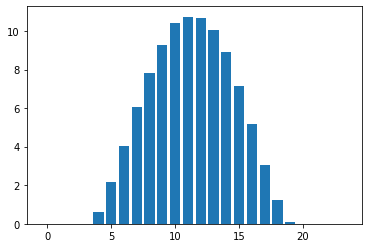

In [88]:
plot_time_dep_result('PV_prod_t[Elec')

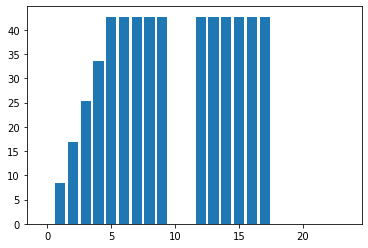

In [87]:
plot_time_dep_result('bat_SOC_t')

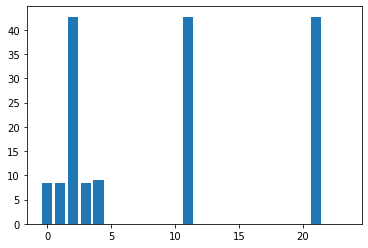

In [76]:
plot_time_dep_result('BAT_cons_t[Elec')

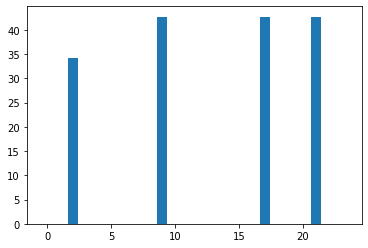

In [77]:
plot_time_dep_result('BAT_prod_t[Elec')

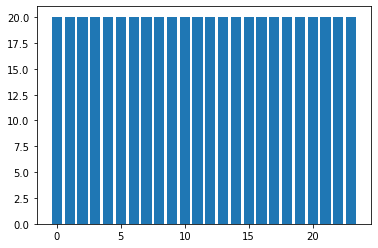

In [78]:
plot_time_dep_result('SOFC_prod_t[Elec')

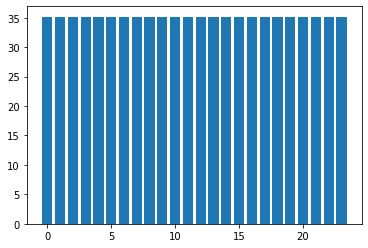

In [79]:
plot_time_dep_result('SOFC_cons_t[Biogas')

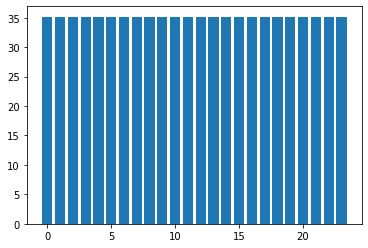

In [80]:
plot_time_dep_result('AD_prod_t[Biogas')

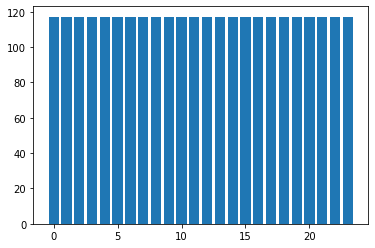

In [81]:
plot_time_dep_result('AD_cons_t[Biomass')

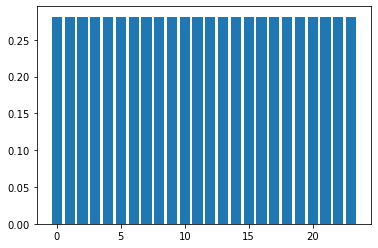

In [53]:
plot_time_dep_result('AD_cons_t[Elec')

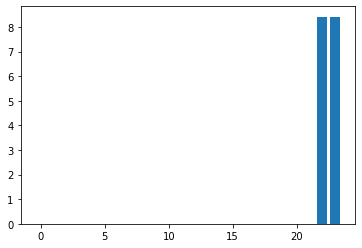

In [54]:
plot_time_dep_result('grid_elec_export_t')

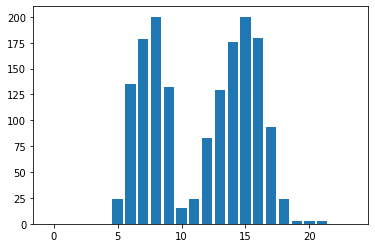

In [55]:
plot_time_dep_result('grid_elec_import_t')

### Result text

In [56]:
# Print all variable values from the optimized model
display_results()

Obj: 2766.37
size[PV] 100
size[BAT] 42.7285
size[SOFC] 20.0465
size[AD] 35.1693
install[PV] 1
install[BAT] 1
install[SOFC] 1
install[AD] 1
CAPEX[PV] 356.566
CAPEX[BAT] 55.9486
CAPEX[SOFC] 103.751
CAPEX[AD] 103.957
grid_elec_export 16.8338
grid_elec_import 1601.22
capex 620.223
opex 2726.58
totex 2766.37

#----------------------------------------------------------------------#
# temporal variables
#----------------------------------------------------------------------#
PV_prod_t[Elec,0] 0
PV_prod_t[Elec,1] 0
PV_prod_t[Elec,2] 0
PV_prod_t[Elec,3] 0.014
PV_prod_t[Elec,4] 0.63
PV_prod_t[Elec,5] 2.142
PV_prod_t[Elec,6] 4.018
PV_prod_t[Elec,7] 6.048
PV_prod_t[Elec,8] 7.84
PV_prod_t[Elec,9] 9.268
PV_prod_t[Elec,10] 10.388
PV_prod_t[Elec,11] 10.738
PV_prod_t[Elec,12] 10.696
PV_prod_t[Elec,13] 10.066
PV_prod_t[Elec,14] 8.918
PV_prod_t[Elec,15] 7.126
PV_prod_t[Elec,16] 5.152
PV_prod_t[Elec,17] 3.066
PV_prod_t[Elec,18] 1.232
PV_prod_t[Elec,19] 0.07
PV_prod_t[Elec,20] 0
PV_prod_t[Elec,21] 0
PV_pro

# Brief results

In [57]:
if not m.status == GRB.INFEASIBLE:
    print('Model Feasible')
else:
    print('Infeasible model -_-')

Model Feasible


In [58]:
# Model Variable values
df_results

,Variable Name,Result,Unit,Lower Bound,Upper Bound
0,size[PV],100.000,None,0.0,10000.0
1,size[BAT],42.728,None,0.0,10000.0
2,size[SOFC],20.046,None,0.0,10000.0
3,size[AD],35.169,None,0.0,10000.0
4,install[PV],1.000,None,0.0,1.0
5,install[BAT],1.000,None,0.0,1.0
6,install[SOFC],1.000,None,0.0,1.0
7,install[AD],1.000,None,0.0,1.0
8,CAPEX[PV],356.566,None,0.0,10000.0
9,CAPEX[BAT],55.949,None,0.0,10000.0


In [59]:
# Model Parameters
P_columns = ['Value', 'Units', 'Description', 'Source', 'Category']
Param_df = pd.DataFrame.from_dict(Param_dict, orient = 'index', columns = P_columns)
Param_df.set_index([list(Param_df['Category']), list(Param_df.index)], inplace = True)
Param_df.drop(columns = 'Category', inplace = True)
Param_df

Value           Units  \
General  Bound              10000.000               -   
Biomass  Pigs                  55.000               -   
         Cows                  65.000               -   
         LSU_pigs               0.500               -   
         LSU                   92.500             LSU   
         Manure_per_cattle      7.300  kg-dry/day/LSU   
         Manure_HHV_dry         4.167      kWh/kg-dry   
         Biomass_prod         117.231           kWh/h   
PV       PV_eff                 0.140               -   
BAT      BAT_eff                1.000               -   
AD       AD_eff                 0.300               -   
         AD_elec_cons           0.008               -   
         SOFC_eff               0.600               -   
         GC_elec_frac           0.030               -   
economic i                      0.025               -   
         n                     20.000           years   
         tau                    0.064               -   

                                                           Description  \
General  Bound                            Default Variable Upper Bound   
Biomass  Pigs                                           Number of Pigs   
         Cows                                           Number of Pigs   
         LSU_pigs                                         LSU per Pigs   
         LSU                                             Number of LSU   
         Manure_per_cattle                    Cattle manure production   
         Manure_HHV_dry                          Manure energy content   
         Biomass_prod                               Biomass Production   
PV       PV_eff                                          PV efficiency   
BAT      BAT_eff                              BAT roundtrip efficiency   
AD       AD_eff                                          AD efficiency   
         AD_elec_cons               AD faction of electricity consumed   
         SOFC_eff                             SOFC electric efficiency   
         GC_elec_frac       gas cleaning electric consumption fraction   
economic i                                        Annual interest rate   
         n                                       years of exploitation   
         tau                                      Annualization factor   

                                             Source  
General  Bound                           Gurobi doc  
Biomass  Pigs                    swissfuturefarm.ch  
         Cows                    swissfuturefarm.ch  
         LSU_pigs                      ec.europa.eu  
         LSU                                   calc  
         Manure_per_cattle    doi: 10.3390/c5020027  
         Manure_HHV_dry       doi: 10.3390/c5020027  
         Biomass_prod                          calc  
PV       PV_eff                                Paul  
BAT      BAT_eff                              guess  
AD       AD_eff                               guess  
         AD_elec_cons       doi: 10.3390/en10081165  
         SOFC_eff                             guess  
         GC_elec_frac          Projet Semestre nils  
economic i                                    guess  
         n                                    guess  
         tau                                   calc

In [60]:
P_columns = ['Value', 'Units', 'Description', 'Source', 'Category']
Param_df = pd.DataFrame.from_dict(Param_dict, orient = 'index', columns = P_columns)
list(Param_df['Category'])

['General',
 'Biomass',
 'Biomass',
 'Biomass',
 'Biomass',
 'Biomass',
 'Biomass',
 'Biomass',
 'PV',
 'BAT',
 'AD',
 'AD',
 'AD',
 'AD',
 'economic',
 'economic',
 'economic']

In [61]:
Param_df.to_csv('Parameters.csv')

In [62]:
handle_csv('Parameters.csv', True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\poopy\\Desktop\\PdM\\GurobiPy\\data\\Parameters.csv'

In [ ]:
df = pd.read_csv('Parameters.csv', engine = 'python')

In [ ]:
df = pd.read_csv('Parameters.csv', engine = 'python')
df.index = df['Name']
for c in df.columns:
    if c != 'Value':
        df.drop(columns = c, inplace = True)
df

In [ ]:
df.set_index(list(df['Category']), list(df['Name']), inplace = True)

In [ ]:
list(df['Name'])

In [ ]:
df